# Simple Raytracer
adapted from https://github.com/jamesbowman/raytrace/blob/master/raytracing.py
by James Bowman, licensed under 3-clause BSD license

In [1]:
from PIL import Image
import numpy as np

In [2]:
# Helper function: normalize vector to length of 1
def normalize(x):
    x /= np.linalg.norm(x)
    return x

In [3]:
# Try it out!
normalize((3,0,0)), normalize((1,1,1))

(array([1., 0., 0.]), array([0.57735027, 0.57735027, 0.57735027]))

## Intersection of a ray and a plane

We want to find out where a ray sent out from the camera hits (intersects) an object. 
We are given a ray starting at point O(rigin) and extending in the direction given by vector D(irection).
The equation for the ray is thus `O + t * D` whereby *t* is a range from -∞ to ∞.

The simplest case to check for intersection is a *plane*.
The plane is defined by a point in 3D space, P(lane) and a normal vector N(ormal) that is perpendicular to the plane.
If a point p lies on the plane, the vector `p - P` is also orthogonal to the normal vector N.
IF two vectors are orthogonal, their dot product is 0.
Thus, for any point p on the plane, the equation `(p - P) * N` is 0.

(see https://tutorial.math.lamar.edu/classes/calciii/eqnsofplanes.aspx)

To determine the intersection, we simply set the equations for our ray and the plane equal and solve for *t*.

In [4]:
# see e.g., https://stackoverflow.com/questions/23975555/how-to-calculate-a-ray-plane-intersection
def intersect_plane(O, D, P, N):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # plane (P, N), or +inf if there is no intersection.
    # O and P are 3D points, D and N (normal) are normalized vectors.
    denom = np.dot(D, N)
    if np.abs(denom) < 1e-6:
        return np.inf
    d = np.dot(P - O, N) / denom
    if d < 0:
        return np.inf
    return d

## Similar approach for spheres

In [5]:
# see https://stackoverflow.com/a/1986458 for an explanation of this equation
def intersect_sphere(O, D, S, R):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # sphere (S, R), or +inf if there is no intersection.
    # O and S are 3D points, D (direction) is a normalized vector, R is a scalar.
    a = np.dot(D, D)
    OS = O - S
    b = 2 * np.dot(D, OS)
    c = np.dot(OS, OS) - R * R
    disc = b * b - 4 * a * c
    if disc > 0:
        distSqrt = np.sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return np.inf

## Functions for defining objects in the scene

In [6]:
def intersect(O, D, obj):
    if obj['type'] == 'plane':
        return intersect_plane(O, D, obj['position'], obj['normal'])
    elif obj['type'] == 'sphere':
        return intersect_sphere(O, D, obj['position'], obj['radius'])

In [7]:
def get_normal(obj, M):
    # Find normal.
    if obj['type'] == 'sphere':
        N = normalize(M - obj['position'])
    elif obj['type'] == 'plane':
        N = obj['normal']
    return N

In [8]:
def get_color(obj, M):
    color = obj['color']
    if not hasattr(color, '__len__'):
        color = color(M)
    return color

In [9]:
def add_sphere(position, radius, color):
    return dict(type='sphere', position=np.array(position), 
        radius=np.array(radius), color=np.array(color), reflection=.5)

In [10]:
def add_plane(position, normal):
    return dict(type='plane', position=np.array(position), 
        normal=np.array(normal),
        color=lambda M: (color_plane0 
            if (int(M[0] * 2) % 2) == (int(M[2] * 2) % 2) else color_plane1),
        diffuse_c=.75, specular_c=.5, reflection=.25)

## Our core raytracing function

In [11]:
def trace_ray(rayO, rayD):
    # Find first point of intersection with the scene.
    t = np.inf
    for i, obj in enumerate(scene):
        t_obj = intersect(rayO, rayD, obj)
        if t_obj < t:
            t, obj_idx = t_obj, i
    # Return None if the ray does not intersect any object.
    if t == np.inf:
        return
    # Find the object.
    obj = scene[obj_idx]
    # Find the point of intersection on the object.
    M = rayO + rayD * t
    # Find properties of the object.
    N = get_normal(obj, M)
    color = get_color(obj, M)
    toL = normalize(L - M)
    toO = normalize(O - M)
    # Shadow: find if the point is shadowed or not.
    l = [intersect(M + N * .0001, toL, obj_sh) 
            for k, obj_sh in enumerate(scene) if k != obj_idx]
    if l and min(l) < np.inf:
        return
    # Start computing the color.
    col_ray = ambient
    # Lambert shading (diffuse).
    col_ray += obj.get('diffuse_c', diffuse_c) * max(np.dot(N, toL), 0) * color
    # Blinn-Phong shading (specular).
    col_ray += obj.get('specular_c', specular_c) * max(np.dot(N, normalize(toL + toO)), 0) ** specular_k * color_light
    return obj, M, N, col_ray

## Set up the scene:

In [12]:
# width and height of image
w = 400
h = 300

# List of objects in our scene.
color_plane0 = 1. * np.ones(3)
color_plane1 = 0. * np.ones(3)
scene = [add_sphere([.75, .1, 1.], .6, [0., 0., 1.]),
         add_sphere([-.75, .1, 2.25], .6, [.5, .223, .5]),
         add_sphere([-2.75, .1, 3.5], .6, [1., .572, .184]),
         add_plane([0., -.5, 0.], [0., 1., 0.]),
    ]

# Light position and color.
L = np.array([5., 5., -10.])
color_light = np.ones(3)

# Default light and material parameters.
ambient = .05
diffuse_c = 1.
specular_c = 1.
specular_k = 50

depth_max = 5  # Maximum number of light reflections.
col = np.zeros(3)  # Current color.
O = np.array([0., 0.35, -1.])  # Camera.
Q = np.array([0., 0., 0.])  # Camera pointing to.
img = np.zeros((h, w, 3))

r = float(w) / h
# Screen coordinates: x0, y0, x1, y1.
S = (-1., -1. / r + .25, 1., 1. / r + .25)

## Now, let's render the scene:

0.0 %|2.5 %|5.0 %|7.5 %|10.0 %|12.5 %|15.0 %|17.5 %|20.0 %|22.5 %|25.0 %|27.500000000000004 %|30.0 %|32.5 %|35.0 %|37.5 %|40.0 %|42.5 %|45.0 %|47.5 %|50.0 %|52.5 %|55.00000000000001 %|57.49999999999999 %|60.0 %|62.5 %|65.0 %|67.5 %|70.0 %|72.5 %|75.0 %|77.5 %|80.0 %|82.5 %|85.0 %|87.5 %|90.0 %|92.5 %|95.0 %|97.5 %|finished!


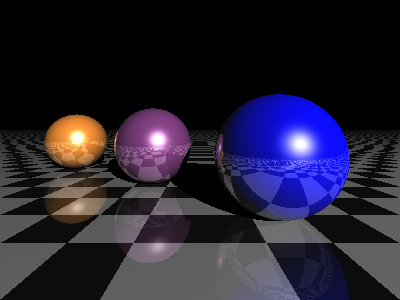

In [13]:
# Loop through all pixels.
for i, x in enumerate(np.linspace(S[0], S[2], w)):
    if i % 10 == 0:
        print(i / float(w) * 100, "%", end="|")
    for j, y in enumerate(np.linspace(S[1], S[3], h)):
        col[:] = 0
        Q[:2] = (x, y)
        D = normalize(Q - O)
        depth = 0
        rayO, rayD = O, D
        reflection = 1.
        # Loop through initial and secondary rays.
        while depth < depth_max:
            traced = trace_ray(rayO, rayD)
            if not traced:
                break
            obj, M, N, col_ray = traced
            # Reflection: create a new ray. see https://math.stackexchange.com/questions/13261/how-to-get-a-reflection-vector
            rayO, rayD = M + N * .0001, normalize(rayD - 2 * np.dot(rayD, N) * N)
            depth += 1
            col += reflection * col_ray
            reflection *= obj.get('reflection', 1.)
        img[h - j - 1, i, :] = np.clip(col, 0, 1)
print("finished!")
im = Image.fromarray((255 * img).astype(np.uint8), "RGB")
display(im)

In [14]:
# im.save("fig.png")

In [ ]:
## Additional Tasks

- What happens if you change different parameters?
- How can we add triangles/meshes?
- How do we add refraction partial translucency?